In this script we try to reproduce the results from ".\enso_project.jl\scripts\train_and_validate_esn.ipynb" without performing a TDE on the input data.

In [2]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [3]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


We use the SST Anomaly Index data with following data split: 80% training data | 10% validation data | 10% test data

In [26]:
# read input data into dictionary
data = Dict()

data["train_data_80"] = CSV.read("data/sst_34_data_split_80/train_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["test_data_80"] = CSV.read("data/sst_34_data_split_80/test_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["val_data_80"] = CSV.read("data/sst_34_data_split_80/val_sst_34_anomaly_80.txt", DataFrame; delim=',', ignorerepeated=true)

# bring into correct format
data["train_data_80"] = Matrix(transpose(Matrix(data["train_data_80"])))
data["test_data_80"] = Matrix(transpose(Matrix(data["test_data_80"])))
data["val_data_80"] = Matrix(transpose(Matrix(data["val_data_80"])))

data

Dict{Any, Any} with 3 entries:
  "train_data_80" => [0.08 -0.2 … 0.98 0.27]
  "val_data_80"   => [0.02 -0.42 … -0.52 -0.64]
  "test_data_80"  => [-1.13 -1.23 … -0.62 -0.71]

### Set hyperparameters
For each data split, we choose suitable hyperparameters by performing a grid search. We use the same grid as with the tde.

In [23]:
# set up universal parameter options of parameter grid
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08, 0.1, 0.12, 0.14]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [60, 70, 80, 90, 100, 110, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 150]
param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_80)

3240

### Train network

In [27]:
# network training
esn_80, W_out_80, val_loss_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
Validation loss = 72.67854001224832
enso_project.ESNHyperparams(80, 0.8, 0.05, 0.1, 0.0)
Validation loss = 20.59991285751607
enso_project.ESNHyperparams(60, 1.0, 0.05, 0.1, 0.0)
Validation loss = 19.8151026026824
enso_project.ESNHyperparams(70, 1.0, 0.05, 0.1, 0.0)
Validation loss = 12.846002345176363
enso_project.ESNHyperparams(90, 1.0, 0.05, 0.1, 0.0)
Validation loss = 6.3086492811798145
enso_project.ESNHyperparams(100, 0.8, 0.14, 0.5, 1.0e-6)
Validation loss = 6.279808788639128


(ESN(1 => 100), OutputLayer successfully trained with output size: 1, 6.279808788639128)

The validation loss is less than in the case with TDE (6.27 vs 30.42)

### Plot prediction

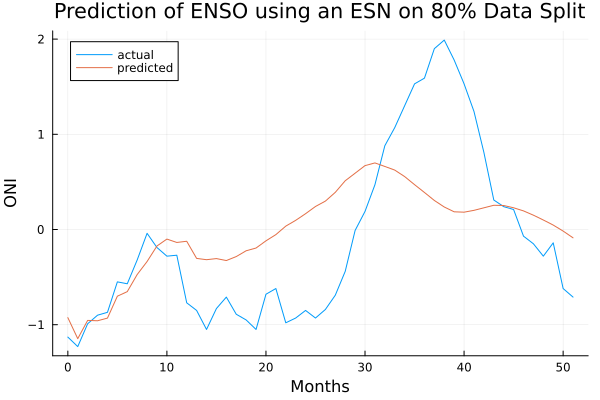

In [58]:
# plot against test data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "80% Data Split")

The prediction abilities are worse than with the TDE.

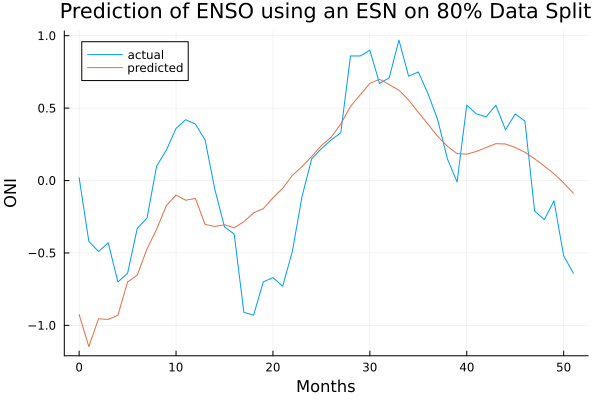

In [53]:
# plot against validation data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["val_data_80"], "80% Data Split")

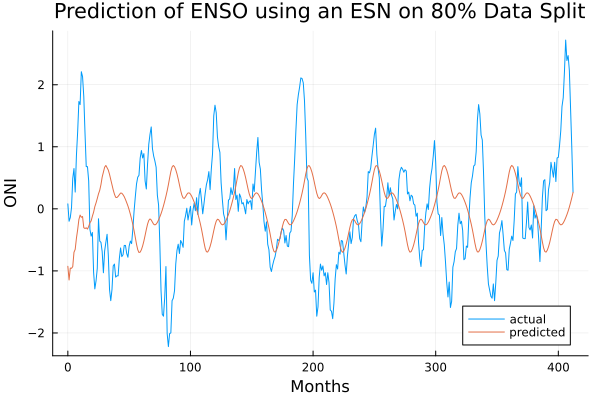

In [55]:
# plot against training data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["train_data_80"], "80% Data Split")

### Evaluation of prediction accuracy

In [43]:
model_prediction = enso_project.esn_eval_pred(esn_80, W_out_80, data["test_data_80"])
model_prediction = transpose(reshape(model_prediction,length(model_prediction),1))

1×52 transpose(::Matrix{Float64}) with eltype Float64:
 -0.925684  -1.14668  -0.954735  …  0.0466095  -0.0164929  -0.0874459

In [42]:
#true_data = data["test_data_80"]
true_data = transpose(reshape(data["test_data_80"], length(data["test_data_80"]),1))

1×52 transpose(::Matrix{Float64}) with eltype Float64:
 -1.13  -1.23  -0.99  -0.9  -0.87  …  -0.15  -0.28  -0.14  -0.62  -0.71

We plot the absolute difference between forecast and true data. We use an error threshold of 0.1.

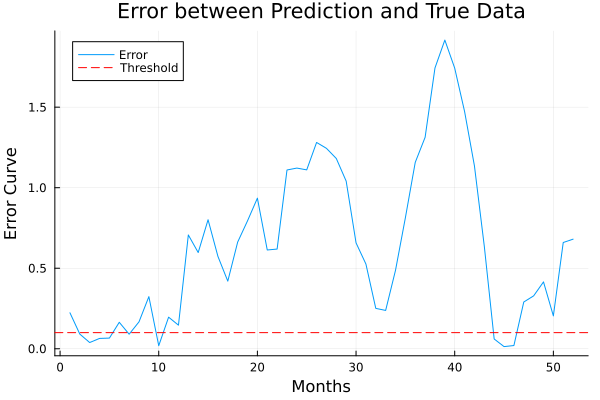

In [57]:
errors = enso_project.forecast_δ_1D(model_prediction, true_data, "abs")
enso_project.plot_error_curve(errors, 0.1)